In [1]:
import pandas as pd
import numpy as np
import math
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import os.path
from os import listdir, chdir
from os.path import isfile, join
import scipy 
from scipy.interpolate import griddata
import matplotlib.colors as colors
import seaborn as sns
#matplotlib widget

In [2]:
# takes a peak center returns what elements that peak is
def what_peak(center):
    if center is np.nan:
        return 'f) unknown'
    elif center >= 1.25 and center <= 1.36:
        return 'e) NMC(003) Peak Width'
    # check this!!! looks like we might be missing graphite
    elif center >= 1.75 and center <= 1.8:
        return 'c) Lithiated Graphite'
    elif center >= 1.8 and center <= 1.85:
        return 'b) Partially Lithiated Graphite'
    elif center >= 1.85 and center <= 1.9:
        return 'a) Graphite'
    elif center >= 2.51 and center <= 2.53:
        return 'd) Li(110)'
    else:
        return 'f) unknown'

In [3]:
# path to the csv the peak fiter scrip9 t made
sample_name = 'S1_LN_10psi_Ch10_0120922_map_01-4'

general_path = r'C:\Users\Elizabeth Allan-Cole\Desktop\XRD Data Processing\NSLS-II Winter 2023\Processing\Initial_fit\Output'
#csv_path = os.path.join(general_path, sample_name, str(sample_name) + '_all_data.csv')

# Graphite only
csv_path = os.path.join(general_path, sample_name, str(sample_name) + '_Graphite-LixC6.csv')

#general_path = r'/nsls2/users/eallancol/Output'
#csv_path = general_path + '/'+ sample_name + '/' + sample_name + '_all_data.csv'
df = pd.read_csv(csv_path)

# add columns for peak names 
df['peak1'] = df['Center1'].apply(what_peak)
df['peak2'] = df['Center2'].apply(what_peak)
df['peak3'] = df['Center2'].apply(what_peak)


# convert the df from wide to long
# for peak1
df_long1 = df.drop(['Gaussian2', 'FWHM2', 'Center2', 'Gaussian3', 'FWHM3',
       'Center3', 'peak2', 'peak3'], axis=1)
df_long1 = df_long1.rename(columns={"Gaussian1": "Gaussian", "FWHM1": "FWHM", "Center1":"Center", "peak1": "peak"})


# for peak 2
df_long2 = df.drop(['Gaussian1', 'FWHM1', 'Center1', 'Gaussian3', 'FWHM3',
       'Center3', 'peak1', 'peak3'], axis=1)
df_long2 = df_long2.rename(columns={"Gaussian2": "Gaussian", "FWHM2": "FWHM", "Center2":"Center", "peak2": "peak"})


# for peak 3
df_long3 = df.drop(['Gaussian1', 'FWHM1', 'Center1', 'Gaussian2', 'FWHM2',
       'Center2', 'peak1', 'peak2'], axis=1)
df_long3 = df_long3.rename(columns={"Gaussian3": "Gaussian", "FWHM3": "FWHM", "Center3":"Center", "peak3": "peak"})

#print(df_long.columns)
df_long = pd.concat([df_long1, df_long2, df_long3]).reset_index(drop = True)
# group the data by point and file FWHM and center gets averaged, peak integral gets sumed
df_long = df_long.groupby(['Sample', 'x motor', 'y motor', 'file_name', 'peak'], as_index=False).agg({'Gaussian':'sum', 'FWHM':'mean', 'Center':'mean'})

In [4]:
def make_graphs(peak_names, df_long, figsize = (25,4)):
    if 'f) unknown' in peak_names:
        peak_names.remove('f) unknown')
    sample_name = df_long['Sample'].unique()
    num_peaks = len(peak_names)
    fig, ax = plt.subplots(1,num_peaks,figsize=figsize,sharey=False) #
    fig.suptitle('Diffraction Peak Heat Maps: ' + sample_name)
    bounds = 256    

    for i, peak in enumerate(peak_names):

        # make a df of only the peak were graphing
        df_temp = df_long.drop(df_long[df_long['peak'] != peak].index).reset_index(drop = True)

        if peak == 'NMC(003) Peak Width':
            my_min = df_temp['FWHM'].min()
            my_max = df_temp['FWHM'].max()
            df_temp = df_temp[['x motor', 'y motor','FWHM',]]
            df_temp = df_temp.pivot_table(index = 'y motor', columns='x motor', values = 'FWHM', aggfunc='mean')
            df_temp = df_temp.fillna(my_min - (my_min * 0.05))
        else:
            my_min = df_temp['Gaussian'].min()
            my_max = df_temp['Gaussian'].max()
            df_temp = df_temp[['x motor', 'y motor','Gaussian']]
            df_temp = df_temp.pivot_table(index = 'y motor', columns='x motor', values = 'Gaussian', aggfunc='mean')
            df_temp = df_temp.fillna(my_min - (my_min * 0.05))


        increment = (my_max - (my_min- my_min * 0.05)) / bounds
        n = 0
        bounds_list = []


        while n <= bounds:
            bounds_list.append(n*increment + (my_min- my_min * 0.05))
            n += 1

        norm = colors.BoundaryNorm(boundaries=bounds_list, ncolors=256)
        sns.heatmap(df_temp, cmap='hot', cbar=True, cbar_kws={'label': peak}, square=True, ax = ax[i], 
                    **{'norm':norm})

        ax[i].set_title(peak)
        ax[i].tick_params(axis='x', rotation=90)
        ax[i].tick_params(axis='y', rotation=0)

    fig.tight_layout()
    plt.show()

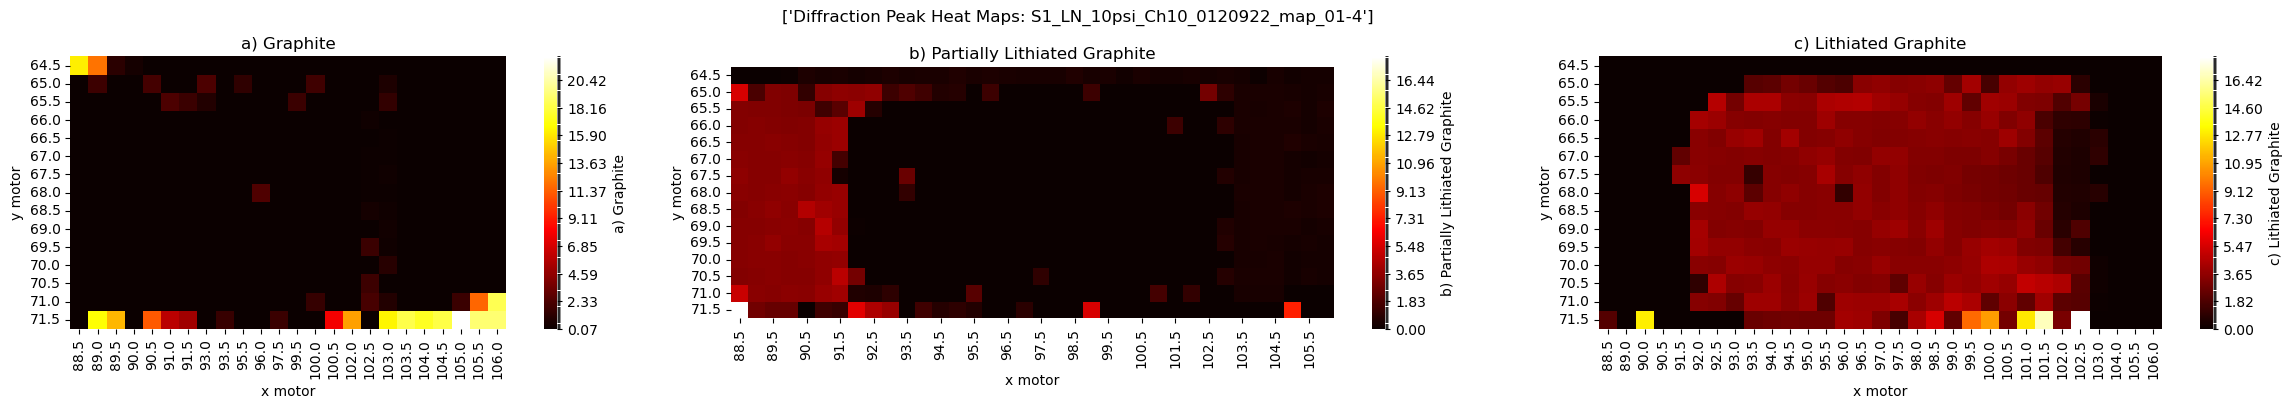

In [8]:
peak_names = list(df_long['peak'].unique())
peak_names = sorted(peak_names, key=lambda x: x[0])
#print(peak_names)

make_graphs(peak_names, df_long)

#graphite = [item for item in peak_names if 'Graphite' in item]
#make_graphs(graphite, df_long, figsize=(25,7))

#not_graphite = [item for item in peak_names if 'NMC' and 'Lith' not in item]
#make_graphs(not_graphite, df_long, figsize=(25,10))


#not_graphite = [item for item in peak_names if 'Graphite' not in item]
#make_graphs(not_graphite, df_long, figsize=(25,10))


In [26]:
print(os.getcwd())

/nsls2/users/eallancol/Output
